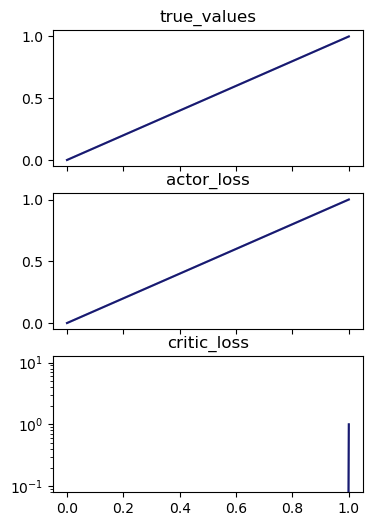

In [5]:
from trainer.trainer import treeTrainer
from agent.agent import normalDistAgent
from env.env import treeEnvB
from env.propagatorB import motionSystemB, CWPropagatorB

import torch
import numpy as np
import matplotlib.pyplot as plt

space_dim = 3
state_dim = space_dim*2
A0 = np.eye(state_dim)
A0 += np.hstack((np.zeros((state_dim,space_dim)), 
                 np.vstack((np.eye(space_dim),np.zeros((space_dim,space_dim))))
                ))
A1 = np.eye(state_dim) + np.random.uniform(low=-0.1, high=0.1, size=(state_dim, state_dim))
A2 = A0 + np.random.uniform(low=-0.1, high=0.1, size=(state_dim, state_dim))

max_dist=10.

# propB = motionSystemB(A0, max_dist=max_dist, device="cuda")
propB = CWPropagatorB(device="cuda")

pop = 512
max_gen = 5400
action_bound = 6e-2
env = treeEnvB.from_propagator(propB, population=pop, max_gen=max_gen, device="cuda")
agent = normalDistAgent(obs_dim=propB.obs_dim, action_dim=propB.action_dim,
    actor_hiddens=[512]*8, critic_hiddens=[512]*8, 
    action_lower_bound=-action_bound, action_upper_bound=action_bound, 
    actor_lr=1E-5, critic_lr=5E-4)
T = treeTrainer(env, agent, gamma=1.)

# T.agent.load("../model/check_point9.ptd")

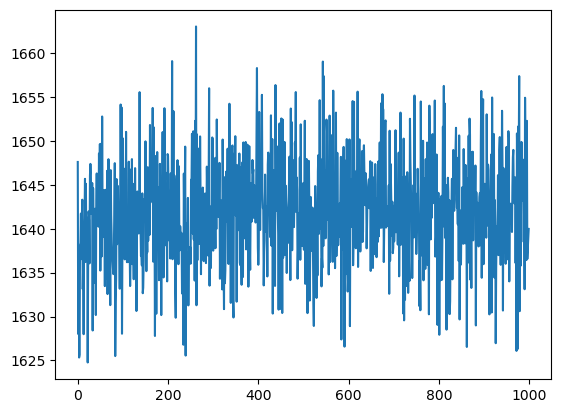

In [6]:
n = 1000
batch = 2560
horizon = 100
rewards = []
for _ in range(n):
    states = T.propagator.T.randomInitStates(batch).to(agent.device)
    reward = T.propagator.seqOptTgt(states, agent, horizon)
    rewards.append(reward.item())
plt.plot(rewards)
plt.show()

In [4]:
T.train(n_episode=10)

Output()

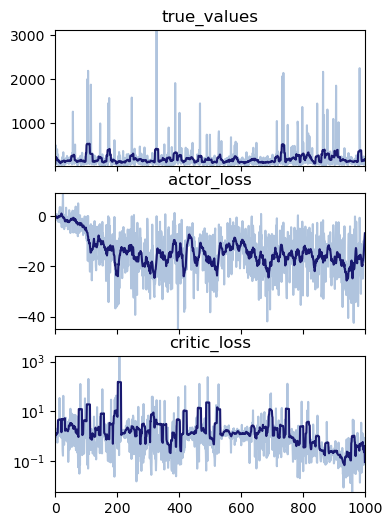

In [5]:
from plotting.dataplot import dataPlot
_ = dataPlot.from_log("../model/log.npz")

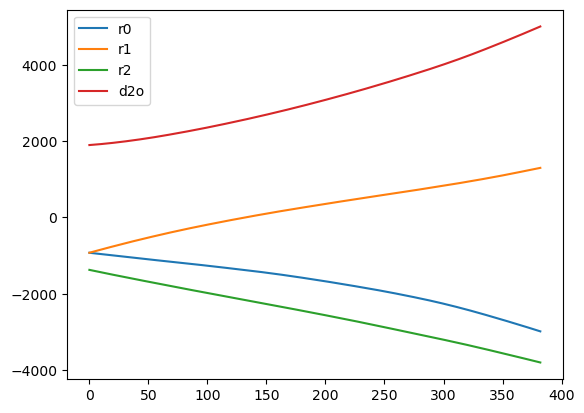

In [6]:
_, d = T.test(decide_mode="gen", t_max=.01, g_max=3)

plt.close("all")
# d = ds[1]
d2o = np.linalg.norm(d["states"][:T.testEnv.episode,:3], axis=1)
for i in range(3):
    plt.plot(d["states"][:T.testEnv.episode,i], label=f"r{i}")
plt.plot(d2o, label=f"d2o")
plt.legend()
plt.show()

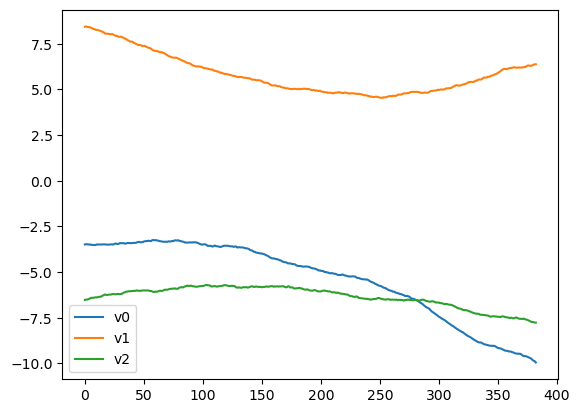

In [7]:
plt.close("all")
# d = ds[1]
d2o = np.linalg.norm(d["states"][:T.testEnv.episode,:3], axis=1)
for i in range(3,6):
    plt.plot(d["states"][:T.testEnv.episode,i], label=f"v{i-3}")
plt.legend()
plt.show()

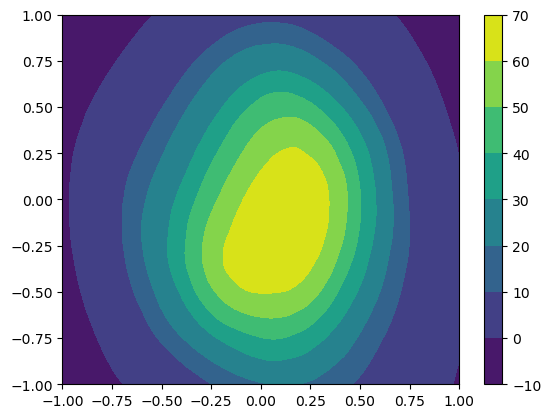

In [10]:
from plotting.analyze import *
criticContour(T.agent, dims=(0,3), span=[-1,1], step=201)